# Summary visualizations for the spectral libraries obtained from Patrick Lowrance

In [8]:
from retrieve_spectral_coverage import *
import itertools
import numpy as np
import pickle


CALSTAR_DIR = '/Users/berlinc/Downloads/calstar_templates'

MISSION = 'targetList_HabEx_4m_coroOnly_DulzE_promo_EPRVmwants_lucky_charAsnr5_binMenn_20190929'
# MISSION = 'targetList_HabEx_4m_LJSoC_DulzE_TV3_EPRVfalse_randluck_GA.0_binMenn_C1R140_a0.15b0c0.05d0e0.3f0.3_20190928b'


LETTER = ['O', 'B', 'A', 'F', 'G', 'K', 'M', 'L', 'T', 'Y']
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ROMAN = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']

# Make a list of spectral types as a reference:
ref_st = []
for i in itertools.product(LETTER, NUMBER, ROMAN): 
    ref_st.append("".join(map(str, i)))


DATA = {}

# Retrieve the target stars' spectral types corresponding to a mission simulation
with open(MISSION + '.pkl','rb') as f: target_spec_types = pickle.load(f)
for i, st in enumerate(target_spec_types):
    target_spec_types[i] = standerize_spec_type(st) # standerize_spec_type is from retrieve_spectral_coverage_utils
# Construct the corresponding 0.5-hot vector based on ref_st
targ_vect = np.zeros(len(ref_st))
mask = np.isin(np.array(ref_st), target_spec_types)
targ_vect[mask] = 0.5


# Get spectral coverages for engelke, current_calspec, cw_spectra, irs_cal, cohen
DATA['engelke'] = getSpCov_engelke()
DATA['irs_cal'] = getSpCov_irs_cal()
DATA['current_calspec'] = getSpCov_calspec(CALSTAR_DIR + '/current_calspec')
DATA['cw_spectra'] = getSpCov_cw_spectra(CALSTAR_DIR + '/cw_spectra')
DATA['cohen'] = getSpCov_cohen(CALSTAR_DIR + '/cohen')

df_input = {}
df_input['spec'] = ref_st

for lib in ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen']:
    cov_vect = np.zeros(len(ref_st))
    mask = np.isin(np.array(ref_st), list(DATA[lib].keys()))
    # Convert the list to one-hot vectors based on the reference spectral-type list
    cov_vect[mask] = 1
    # Modify the lists based on target spectral types: 
    #  0:not covered/not needed, 0.5:not covered/needed, 1:covered/not needed, 1.5:covered/needed
    cov_vect = cov_vect + targ_vect
    cov_vect[cov_vect == 0] = np.nan
    df_input[lib] = cov_vect

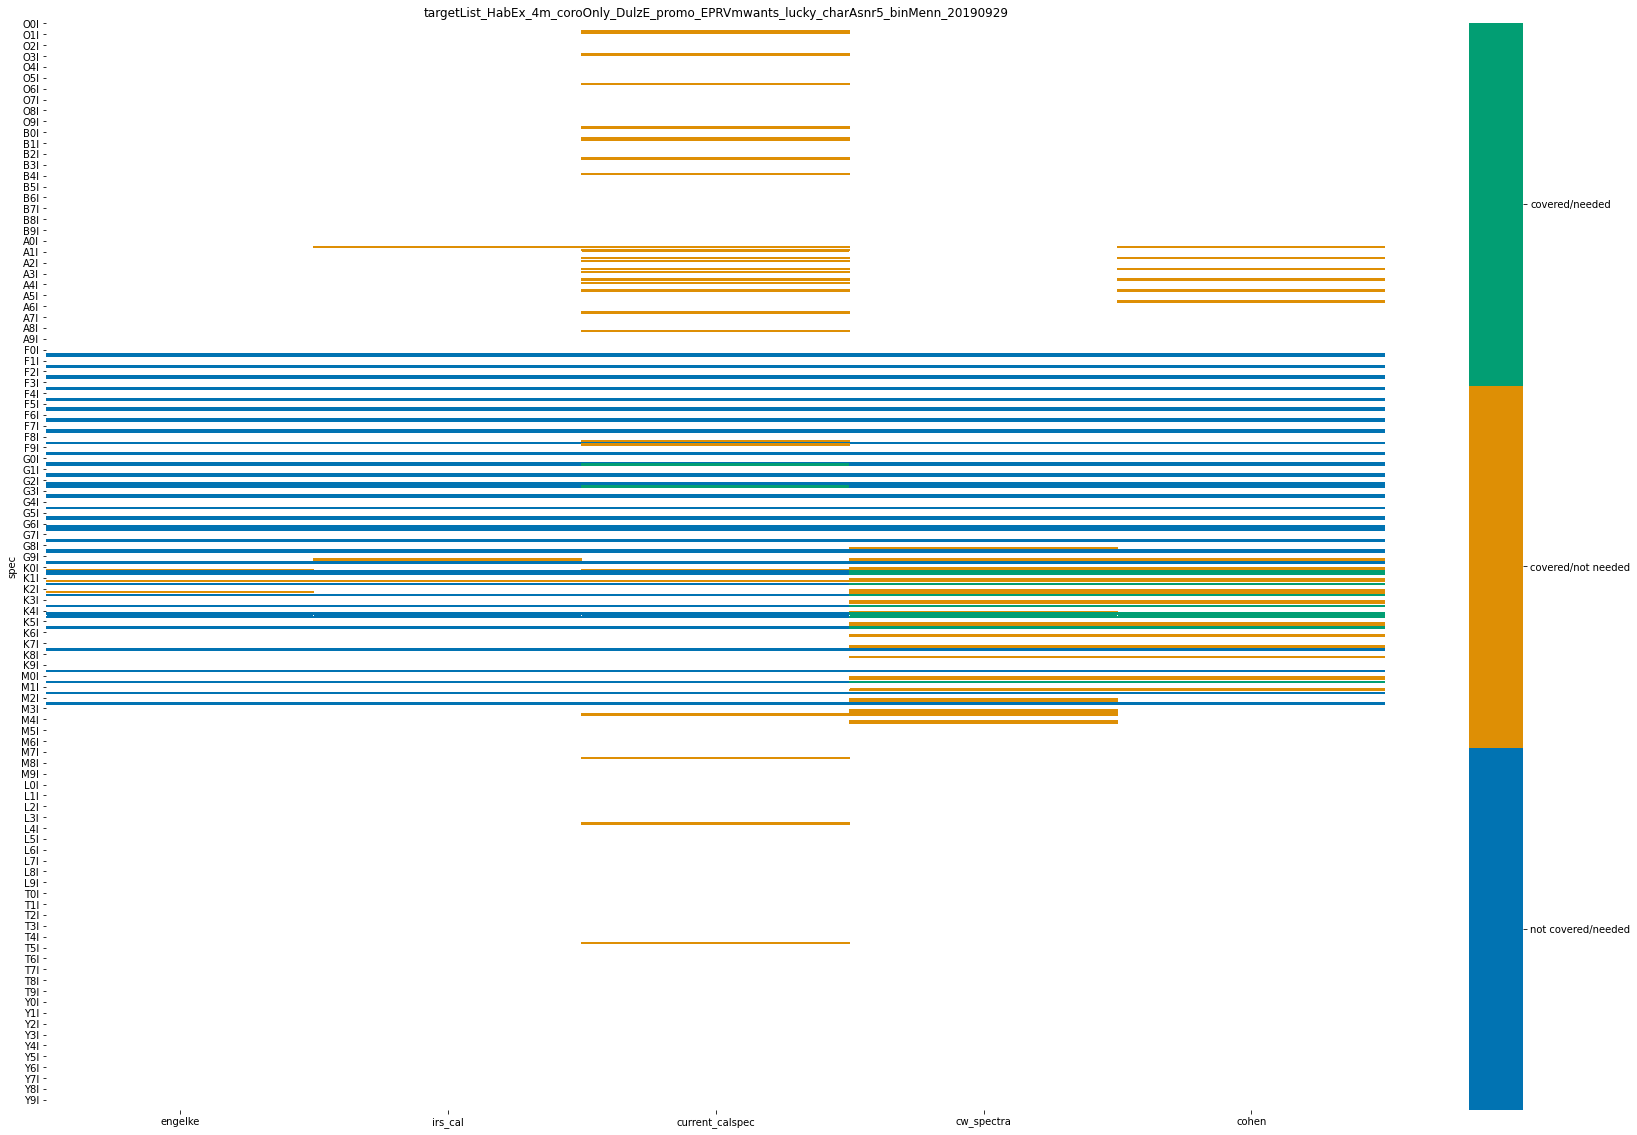

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))

# Create pandas dataframe:
df = pd.DataFrame(df_input)
df = df.set_index('spec')

# Plot/save heatmap with discrete colorscheme, following https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot

vmap = {0.5: 'not covered/needed', 1: 'covered/not needed', 1.5: 'covered/needed'}
n = 3

cmap = sns.color_palette("colorblind", n)
ax = sns.heatmap(df, cmap=cmap)

# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
ax.title.set_text(MISSION)
plt.savefig(MISSION + '.png', dpi=300)

In [3]:
# Construct all the necessary data objects for the horizontal bar plot (see the next cell):

# NOTE: We need spec_type_index_map, spec_type_filter_map, filtered_ref_st, and filtered_spec_type_indices 
#  because we want to compress the list of possible spectral types (in the y-axis of the plot) into only 
#  those found in spec_type_indices, otherwise there will be too many y values to visualize.

spec_type_index_map = {}
for i, rt in enumerate(ref_st):
    spec_type_index_map[rt] = i


dataset_indices = []
spec_type_indices = []
dataset_names = ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen']
intervals = []
for di, dataset in enumerate(dataset_names):
    for spec_type in DATA[dataset].keys():
        dataset_indices.append(di)
        spec_type_indices.append(spec_type_index_map[spec_type])
        intervals.append(DATA[dataset][spec_type])
    
    
spec_type_filter_map = {}
filtered_ref_st = []
i = 0
for st_i in sorted(spec_type_indices):
    if st_i in spec_type_filter_map:
        continue
    spec_type_filter_map[st_i] = i
    filtered_ref_st.append(ref_st[st_i])
    i += 1

    
filtered_spec_type_indices = []
for st_i in spec_type_indices:
    filtered_spec_type_indices.append(spec_type_filter_map[st_i])

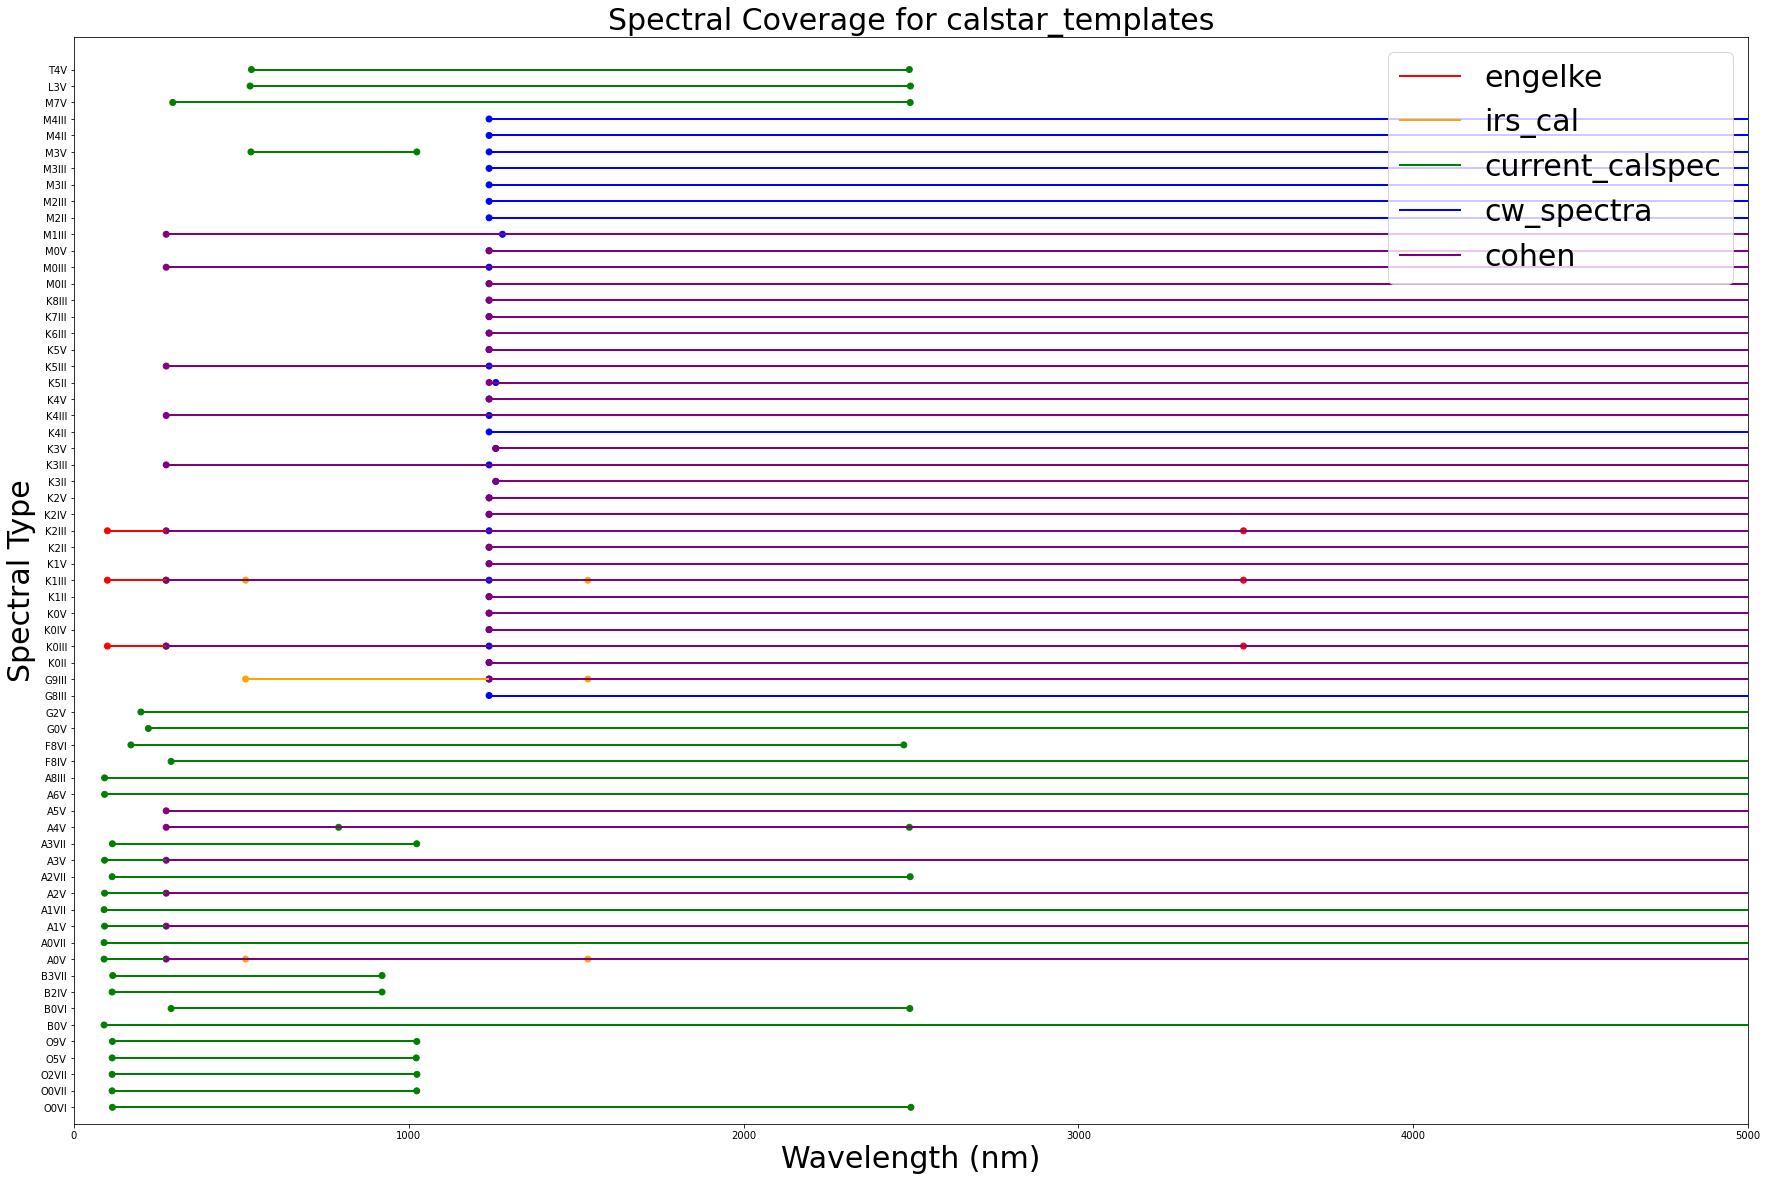

In [12]:
# Plot coverage as a function of spectral type:
#  (some code taken from stackoverflow.com/questions/56584939/matplotlibs-build-in-interval-plot)

from matplotlib.lines import Line2D # Imported for legends
import numpy as np
from matplotlib import collections  as mc

ANNOT = False # Whether to annotate the ranges (Warning: if True then an error will be encountered but we
                # still obtain the desired .png image inspite of the error)

num_datasets = len(dataset_names)
unique_colors = ['red', 'orange', 'green', 'blue', 'purple']
colors = np.array([unique_colors[idx] for idx in dataset_indices])

# viridis = plt.cm.get_cmap('viridis', len(dataset_names))
# unique_colors = np.array([viridis(idx / num_datasets) for idx in np.arange(len(dataset_names)) + 1])
# colors = np.array([viridis(idx / num_datasets) for idx in np.array(dataset_indices) + 1])


# Prepare the input data in correct format for LineCollection 
lines = [[(i[0], j), (i[1], j)] for i, j in zip(intervals, filtered_spec_type_indices)]#range(len(intervals)))]

lc = mc.LineCollection(lines, colors= colors, linewidths=2)
fig, ax = plt.subplots(figsize=(30, 20))#figsize=(50, 30))
ax.add_collection(lc)
ax.margins(0.1)
plt.yticks(range(len(filtered_ref_st)), filtered_ref_st)

# Adding the legends
def make_proxy(col, scalar_mappable, **kwargs):
    color = col 
    return Line2D([0, 1], [0, 1], color=color, **kwargs)
proxies = [make_proxy(c, lc, linewidth=2) for c in unique_colors]

ax.legend(proxies, dataset_names, fontsize=30)

# Adding annotations
if ANNOT:
    for i, x, c in zip(filtered_spec_type_indices, intervals, range(len(spec_type_indices))):
        plt.text(x[0], i+0.1, x[0], color=colors[c])
        plt.text(x[1], i+0.1, x[1], color=colors[c])
    
#Add dots to the end of lines:
x = [i[0] for j in lines for i in j]
y = [i[1] for j in lines for i in j]
c = [col for col in colors for _ in (0, 1)]

ax.scatter(x, y, c=c)

#NOTE: restricting x limits makes the displayed plot tiny in Jupyterhub, so see the saved png.
ax.set_xlim([0, 5000]) 
ax.set_ylim([-1, len(filtered_ref_st) + 1])

ax.set_title('Spectral Coverage for calstar_templates', fontsize=30)
ax.set_xlabel('Wavelength (nm)', fontsize=30)
ax.set_ylabel('Spectral Type', fontsize=30)

if ANNOT:
    plt.savefig('spectral_coverage_barplot_annot.png')
else:
    plt.savefig('spectral_coverage_barplot.png')

In [9]:
# Prints numerical summary:

print(MISSION[11:80] + '... :')
print(' There are ' + str(len(target_spec_types)) + ' target spectral types.')
print(' Of those:')
for lib in ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen']:
    tmp = df_input[lib]
    tmp = tmp[~np.isnan(tmp)]
    unique, counts = np.unique(tmp, return_counts=True)
    counter = dict(zip(unique, counts))
    if 1.5 not in counter: counter[1.5] = 0 
    print('  ' + str(counter[1.5]) + ' are covered by ' + lib + ', which has ' \
      + str(counter[1] + counter[1.5]) + ' spectral types.')

HabEx_4m_coroOnly_DulzE_promo_EPRVmwants_lucky_charAsnr5_binMenn_2019... :
 There are 422 target spectral types.
 Of those:
  0 are covered by engelke, which has 3 spectral types.
  0 are covered by irs_cal, which has 3 spectral types.
  2 are covered by current_calspec, which has 30 spectral types.
  9 are covered by cw_spectra, which has 36 spectral types.
  9 are covered by cohen, which has 33 spectral types.


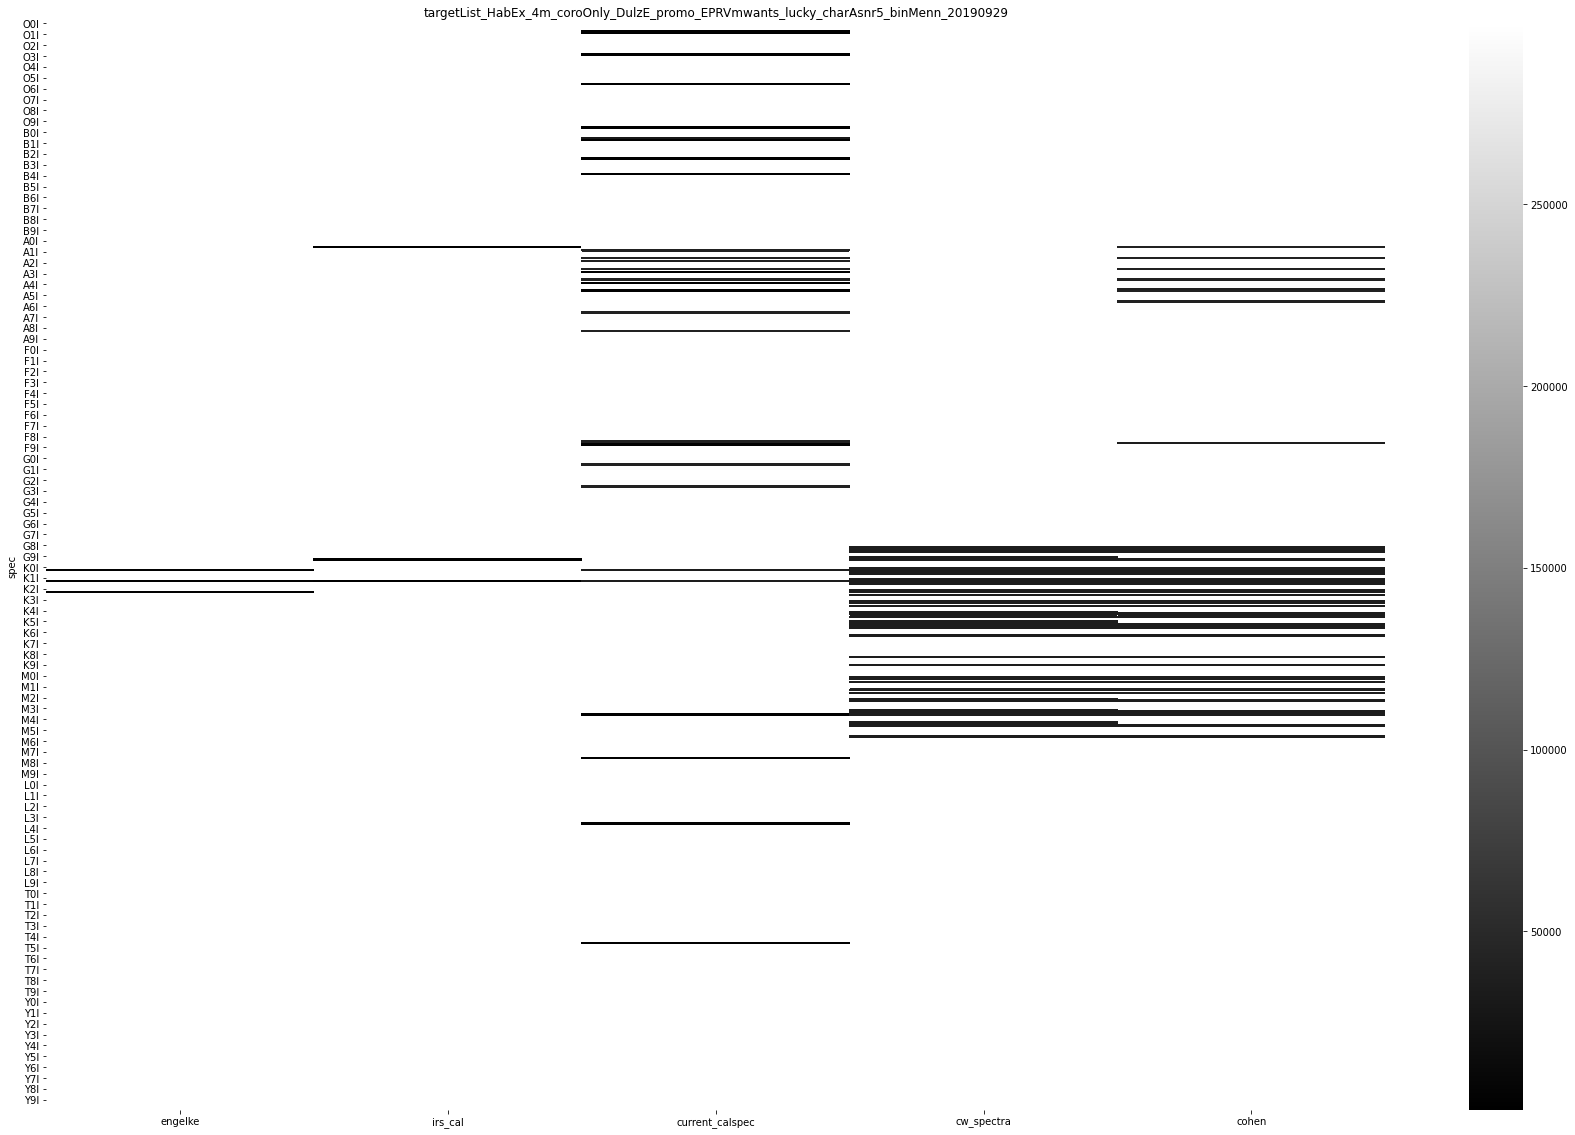

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_input = {}
df_input['spec'] = ref_st

for lib in ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen']:
    cov_vect = np.zeros(len(ref_st))
    # Convert the list to one-hot vectors based on the reference spectral-type list
    for i, st in enumerate(ref_st):
        if st in DATA[lib]:
            cov_vect[i] = DATA[lib][st][1]
    cov_vect[cov_vect == 0] = np.nan
    df_input[lib] = cov_vect

plt.figure(figsize=(30, 20))

# Create pandas dataframe:
df = pd.DataFrame(df_input)
df = df.set_index('spec')

ax = sns.heatmap(df, cmap='gray')
ax.title.set_text(MISSION)

In [27]:
# Prints numerical summery of coverage:

import pandas as pd

pd.set_option('display.max_rows', None)

spec_type, min_spec, max_spec = [], [], []
d = DATA['cohen']

for k in d.keys():
    spec_type.append(k)
    min_spec.append(d[k][0])
    max_spec.append(d[k][1])
    
df = pd.DataFrame({'Spectral Type': spec_type, 'Min wavelength (nm)': min_spec, 'Max wavelength (nm)': max_spec})
df = df.set_index('Spectral Type')
df

,Min wavelength (nm),Max wavelength (nm)
Spectral Type,,
K1III,275.5,35000.0
G8V,275.5,35000.0
A0V,275.5,40000.0
K1IV,275.5,35000.0
K2V,275.5,35080.0
K0III,275.5,35000.0
A3V,275.5,40000.0
K3III,1240.0,35080.0
K2III,1240.0,35080.0
